## Imports

In [25]:
import sys
import os
import random
import math

# For inclusion of path
# BASE_PATH = ''
# sys.path.append(BASE_PATH)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from skimage.io import imread, imshow, imsave
from skimage.morphology import label, remove_small_objects
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

from scipy.stats import pearsonr
from scipy.ndimage.morphology import distance_transform_edt

from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, Input, Flatten
from keras.layers.merge import concatenate, add
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.optimizers import Adam, Nadam, SGD

from keras import backend as K
import tensorflow as tf

from data_prep import generate_train_val_test_ids, get_image_mask_data, get_data_generator
from loss import dice_coef, numpy_dice_coef, dice_coef_loss
from model import get_unet

In [26]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
BATCH_SIZE = 4

IMGS_PATH = '/data/Images/'
MASK_PATH = '/data/Masks/'

## Obtain Image and Mask data

In [3]:
train_val_ids, test_ids, split_cutoff = generate_train_val_test_ids(img_path=IMGS_PATH)

Total number of training and validation: 414
Total number of test: 100
Training set = 331 and Validation set = 83


### Training/Validation/Test Set

In [4]:
X_train, Y_train, X_test, Y_test = get_image_mask_data(IMGS_PATH, MASK_PATH, train_val_ids, test_ids)

100%|██████████| 100/100 [00:01<00:00, 95.46it/s]


## Build Generators

In [5]:
train_generator, val_generator = get_data_generator(X_train, Y_train, split_cutoff)

## Visualize Images

Text(0.5, 1.0, 'Validation Mask')

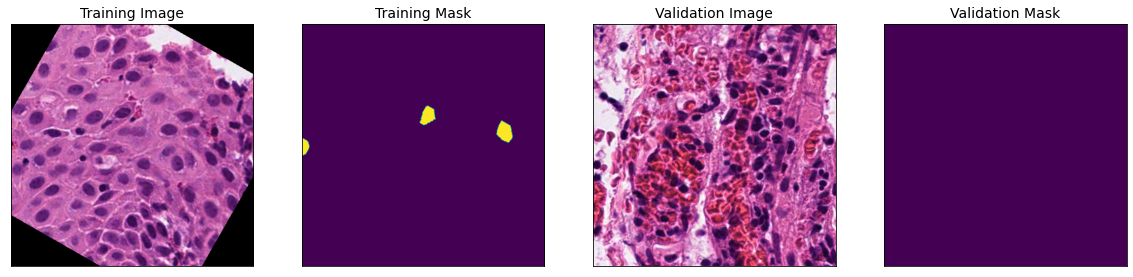

In [8]:
x, y = next(train_generator)
x_val, y_val = next(val_generator)

fig1, ax1 = plt.subplots(1,4,figsize=(20,12))
ax1[0].imshow(x[0])
ax1[0].set_xticks([])
ax1[0].set_yticks([])
ax1[0].set_title('Training Image', fontsize=14)
ax1[1].imshow(np.squeeze(y[0]))
ax1[1].set_xticks([])
ax1[1].set_yticks([])
ax1[1].set_title('Training Mask', fontsize=14)
ax1[2].imshow(x_val[0])
ax1[2].set_xticks([])
ax1[2].set_yticks([])
ax1[2].set_title('Validation Image', fontsize=14)
ax1[3].imshow(np.squeeze(y_val[0]))
ax1[3].set_xticks([])
ax1[3].set_yticks([])
ax1[3].set_title('Validation Mask', fontsize=14)

## Build UNet

In [16]:
### Compile 
input_img = Input(shape=(512, 512, 3))
model = get_unet(input_img)
model.compile(optimizer=Adam(lr=2e-4), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

Contract1
Contract2
Contract3
Contract4
Expand1
Expand2
Expand3
Expand4
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 512, 512, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 512, 512, 32) 128         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 512, 512, 32) 0           batch_normalization_18[0][0]     
____________________

## Train Model

In [21]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

num_train_val = len(train_val_ids)
steps_per_epoch = compute_steps_per_epoch(split_cutoff)
val_steps = compute_steps_per_epoch(num_train_val - split_cutoff)

earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('Final_Eo_Model2.h5', verbose = 1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator,
                              validation_steps = val_steps,
                              steps_per_epoch = steps_per_epoch,
                              epochs=2, callbacks=[checkpointer,earlystopper])

/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
83/83 [==============================] - 118s 772ms/step - loss: -0.0416 - dice_coef: 0.0416 - val_loss: -0.0435 - val_dice_coef: 0.0434

Epoch 00001: val_loss improved from inf to -0.04355, saving model to Final_Eo_Model2.h5
Epoch 2/2
83/83 [==============================] - 16s 189ms/step - loss: -0.0741 - dice_coef: 0.0741 - val_loss: -0.0472 - val_dice_coef: 0.0475

Epoch 00002: val_loss improved from -0.04355 to -0.04725, saving model to Final_Eo_Model2.h5


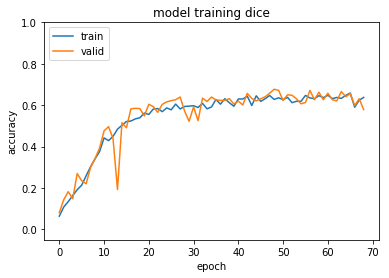

In [18]:
# summarize history for accuracy
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('model training dice')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(-.05,1)
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Evaluate Model

In [10]:
# When you plan to re-train model - Must run Loss Function cell
model = load_model('DeepEoE.model', compile=False)

preds_test = model.predict(X_test * 255,verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.bool)

test_dice = numpy_dice_coef(Y_test, preds_test_t)
print(test_dice)

100/100 [==============================] - 12s 120ms/step
0.651585942728363


In [11]:
# When you plan to re-train model - Must run Loss Function cell
model = load_model('Final_Eo_Model.h5', compile=False)

preds_test = model.predict(X_test,verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.bool)

test_dice = numpy_dice_coef(Y_test, preds_test_t)
print(test_dice)

100/100 [==============================] - 20s 195ms/step
0.6955016927586285


### Test Sample

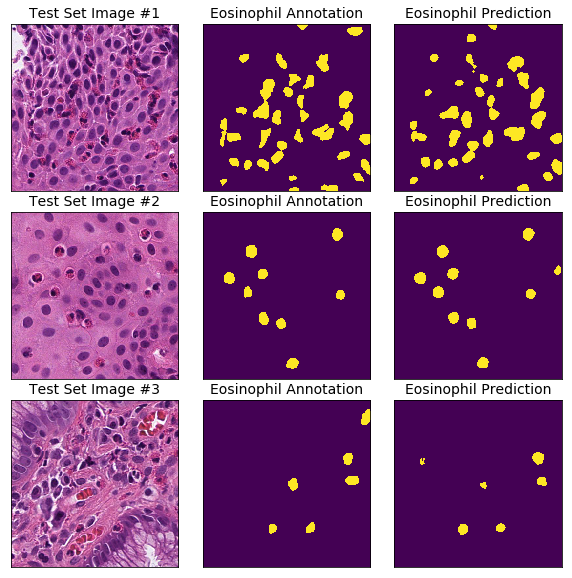

In [14]:
# Perform a sanity check on some random validation samples
ix_1 = 0 # change as necessary
ix_2 = ix_1 + 1
ix_3 = ix_2 + 1

fig1, ax1 = plt.subplots(3,3,figsize=(10,10))
ax1[0,0].imshow(np.squeeze(X_test[ix_1]))
ax1[0,0].set_title('Test Set Image #1', fontsize=14)
ax1[0,0].set_xticks([])
ax1[0,0].set_yticks([])
ax1[0,1].imshow(np.squeeze(Y_test[ix_1]))
ax1[0,1].set_title('Eosinophil Annotation', fontsize=14)
ax1[0,1].set_xticks([])
ax1[0,1].set_yticks([])
ax1[0,2].imshow(np.squeeze(preds_test_t[ix_1]))
ax1[0,2].set_title('Eosinophil Prediction', fontsize=14)
ax1[0,2].set_xticks([])
ax1[0,2].set_yticks([])

ax1[1,0].imshow(np.squeeze(X_test[ix_2]))
ax1[1,0].set_title('Test Set Image #2', fontsize=14)
ax1[1,0].set_xticks([])
ax1[1,0].set_yticks([])
ax1[1,1].imshow(np.squeeze(Y_test[ix_2]))
ax1[1,1].set_title('Eosinophil Annotation', fontsize=14)
ax1[1,1].set_xticks([])
ax1[1,1].set_yticks([])
ax1[1,2].imshow(np.squeeze(preds_test_t[ix_2]))
ax1[1,2].set_title('Eosinophil Prediction', fontsize=14)
ax1[1,2].set_xticks([])
ax1[1,2].set_yticks([])
                
ax1[2,0].imshow(np.squeeze(X_test[ix_3]))
ax1[2,0].set_title('Test Set Image #3', fontsize=14)
ax1[2,0].set_xticks([])
ax1[2,0].set_yticks([])
ax1[2,1].imshow(np.squeeze(Y_test[ix_3]))
ax1[2,1].set_title('Eosinophil Annotation', fontsize=14)
ax1[2,1].set_xticks([])
ax1[2,1].set_yticks([])
ax1[2,2].imshow(np.squeeze(preds_test_t[ix_3]))
ax1[2,2].set_title('Eosinophil Prediction', fontsize=14)
ax1[2,2].set_xticks([])
ax1[2,2].set_yticks([])
               
plt.subplots_adjust(wspace=0.1, hspace=0.12)

## Test Counting

In [11]:
test_counts = np.zeros(num_test, dtype=np.uint8)
pred_test_count = np.zeros(num_test, dtype=np.uint8)
for i in range(num_test):
    labels, count = label(Y_test[i], return_num = True)
    test_counts[i] =  count
    mask = remove_small_objects(label(preds_test_t[i]),200)
    labels, count = label(distance_transform_edt(mask) > 8, return_num = True)
    pred_test_count[i] = count    

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?


In [68]:
features = pd.DataFrame()
features['file_name'] = test_ids
features['final_counts'] = pred_test_count
features.head()

,file_name,final_counts
0,E-116_5_130049_55809.jpg,20
1,E-116_5_130049_56321.jpg,21
2,E-116_5_130561_55809.jpg,24
3,E-116_5_130561_56321.jpg,26
4,E-116_5_131585_62465.jpg,30


Equation: y = 0.948x + (1.385)
Corr = 0.856


([<matplotlib.axis.XTick at 0x7f3c7113e588>,
 <a list of 8 Text xticklabel objects>)

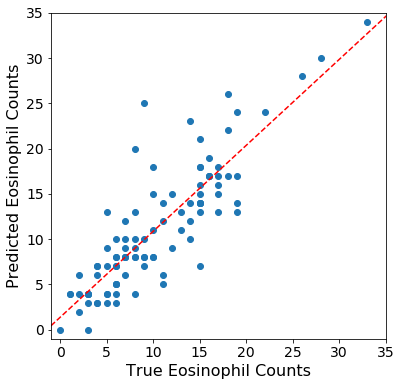

In [12]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(test_counts,pred_test_count,'o')
z = np.polyfit(test_counts,pred_test_count,1)
p = np.poly1d(z)
plt.plot(np.arange(-1,40),p(np.arange(-1,40)),"r--")
#plt.title("Test Set Cell Counts", fontsize=16)
plt.xlabel("True Eosinophil Counts", fontsize=16)
plt.ylabel("Predicted Eosinophil Counts", fontsize=16)
plt.xlim(-1,35)
plt.ylim(-1,35)
#plt.xaxis.major_locator(MaxNlocator(integer=True))
# the line equation:
print("Equation: y = %.3fx + (%.3f)"%(z[0],z[1]))
print("Corr = %0.3f" %pearsonr(test_counts,pred_test_count)[0])

yint = []
#locs, labels = plt.yticks()
for each in range(0,40,5):
    yint.append(int(each))
plt.yticks(yint, fontsize=14)
plt.xticks(yint, fontsize=14)

In [38]:
# Unet 0.75
abs_true_counts = (pred_test_count.astype(int) - test_counts.astype(int))
avg_diff = np.sum(abs_true_counts) / len(abs_true_counts)
print(avg_diff)
print(avg_diff*16)
print(np.std(abs_true_counts))

-0.11678832116788321
-1.8686131386861313
1.391138238108578


([<matplotlib.axis.XTick at 0x7f31b69846d0>,
 <a list of 13 Text xticklabel objects>)

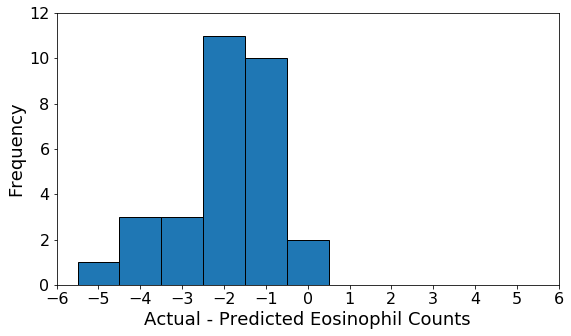

In [47]:
plt.rcParams['figure.figsize'] = [9, 5]
plt.hist(abs_true_counts,bins=range(-5,6,1),edgecolor='black',align='left')
plt.xlabel('Actual - Predicted Eosinophil Counts',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xlim(-4,4)
plt.ylim(0,12)
yint = []
for each in range(0,13,2):
    yint.append(int(each))
plt.yticks(yint,fontsize=16)
xint = []
for each in range(-6,7,1):
    xint.append(int(each))
plt.xticks(xint,fontsize=16)